In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation
import statistics

Using TensorFlow backend.


In [2]:
#讀資料
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test_answer = pd.read_csv('gender_submission.csv')

In [3]:
# drop 掉關係較小的attribute
df_train.drop('PassengerId', axis = 1, inplace=True)
df_train.drop('Name', axis = 1, inplace=True)
df_train.drop('Ticket', axis = 1, inplace=True)
df_train.drop('Cabin', axis = 1, inplace=True)
df_train.drop('Embarked', axis = 1, inplace=True)
#df_train.drop('Parch', axis = 1, inplace=True)
#df_train.drop('SibSp', axis = 1, inplace=True)

df_test.drop('PassengerId', axis = 1, inplace=True)
df_test.drop('Name', axis = 1, inplace=True)
df_test.drop('Ticket', axis = 1, inplace=True)
df_test.drop('Cabin', axis = 1, inplace=True)
df_test.drop('Embarked', axis = 1, inplace=True)
#df_test.drop('Parch', axis = 1, inplace=True)
#df_test.drop('SibSp', axis = 1, inplace=True)


## 做資料Normalize和賦值

In [4]:
age1 = df_train['Age']
age2 = df_test['Age']
avgage1 = age1.sum(axis = 0, skipna = True) /len(age1)
avgage2 = age2.sum(axis = 0, skipna = True) /len(age2)
#把原本是NAN的賦予平均值
df_train['Age'].fillna(avgage1, inplace = True)
df_test['Age'].fillna(avgage2, inplace = True)
df_train['Age'] = df_train['Age']/avgage1
df_test['Age'] =df_test['Age']/avgage2


fare1 = df_train['Fare']
fare2 = df_test['Fare']
avgfare1 = fare1.sum(axis = 0, skipna = True) /len(fare1)
avgfare2 = fare2.sum(axis = 0, skipna = True) /len(fare2)
df_train['Fare'] = df_train['Fare']/avgfare1
df_test['Fare'] =df_test['Fare']/avgfare2


sex_map = {'male' : 0, 'female' :1}
df_train['Sex'] = df_train['Sex'].map(sex_map)
df_test['Sex'] = df_test['Sex'].map(sex_map)


# df_train.fillna('C')
# df_test.fillna('C')
# embark = {'S':1,'C':2,'Q':3}
# df_train['Embarked'] = df_train['Embarked'].map(embark)
# df_test['Embarked'] = df_test['Embarked'].map(embark)

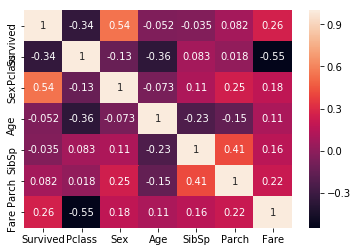

In [5]:
train_corr = df_train.corr()
sns.heatmap(train_corr,annot=True)

In [6]:
train_y = df_train['Survived'].values
test_y = df_test_answer['Survived'].values

df_train = df_train.drop('Survived', 1)

In [7]:
df_train.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,0,0.924397,1,0,0.225126
1,1,1,1.596686,1,0,2.213478
2,3,1,1.092469,0,0,0.246086
3,1,1,1.470632,1,0,1.648853
4,3,0,1.470632,0,0,0.249967
5,3,0,1.000000,0,0,0.262646
6,1,0,2.268975,0,0,1.610426
7,3,0,0.084036,3,1,0.654418
8,3,1,1.134487,0,2,0.345709
9,2,1,0.588253,1,0,0.933754


# Deep Neural Network
1. 15 layers
2. 100 units
3. dropout rate = 0.3

In [8]:
model = Sequential()
model.add(Dense(units=100, input_dim=6, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(0.3))
for i in range(15):
    model.add(Dropout(0.3))
    model.add(Dense(units=100,kernel_initializer='normal', activation='relu'))
    
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))

#編譯: 選擇損失函數、優化方法及成效衡量方式\n",
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

training = []
testing = []
for i in range(1):
    train_history = model.fit(x=df_train, y=train_y, verbose=0, validation_split=0.2, epochs=50, batch_size=64)

    train_result = model.evaluate(df_train, train_y)
    test_result = model.evaluate(df_test, test_y)#test our model

    #scores[0]是loss、scores[1]是accuracy\n",
    print("training data = {:2.5f}%".format(train_result[1]*100.0))
    print("testing data = {:2.5f}%".format(test_result[1]*100.0))
    
    training.append(train_result[1])
    testing.append(test_result[1])

print(statistics.mean(training)*100,'%')
print(statistics.mean(testing)*100,'%')

418/418 [==============================] - 0s 100us/step
training data = 80.80808%
testing data = 97.84689%
80.80808089504606 %
97.84688995215312 %


In [9]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()

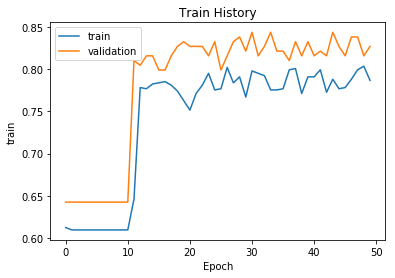

In [10]:
show_train_history(train_history, 'acc', 'val_acc')

# Discussion
+ 15層+100units+dropout=0.3,跑50 epoch ,使用Pclass, Sex, Age, SibSp, Parch, Fare這6個feature
+ 其中Age和Fare有做normalize，就是把原本的數字除以平均

    - training accuracy 81.537%
    - testing accuracy 94.617%
    
+ 上面是做十次取平均的結果
+ 在同樣的testing accuracy有時會跑到98%，但也會掉到85%左右
+ 實際多跑幾次testing accuracy大概會落在90%~95%之間